***STEPS FOR QUERYING STRUCTURAL VARIANT VCF FILE, GETTING THE INTERSECT WITH GOOD PLOTS, AND PLOTTING THE PCA***

Query the Smoove .vcf file for all SV calls with alternate genotypes

In [55]:
#%%bash
#VCF=sparrow_all.smoove.square.vcf.gz

#bcftools query -f '%CHROM\t%POS\t%END\t%ALT[\t%GT]\n' ${VCF} | sort -k1,1 -k2,2n | grep CM | grep -v '\[' | grep -v '\]' | sed 's/<DEL>/DEL/g' | sed 's/<DUP>/DUP/g' | sed 's/<INV>/INV/g' > SV_altgenos.bed

STEP 1 - filter out only the Good calls in the report:

Filter for number of SVs in report by desired person, reorganize columns for order chrom, start pos,stop pos, SV type:

***Filter for both Yes's and Maybe's for each of the five curators***

First set the file names and curator names as variables

Then extract all Yes's and Maybes

In [1]:
%%bash
RAWDEL=raw_report_del_dec23_2020.tsv
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish
#set the SV class
SV=DEL

#Extract all Yes's
cat ${RAWDEL} | grep "${CUR1}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR1}.tsv
cat ${RAWDEL} | grep "${CUR2}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR2}.tsv
cat ${RAWDEL} | grep "${CUR3}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR3}.tsv
cat ${RAWDEL} | grep "${CUR4}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR4}.tsv

Now extract all Maybes

In [3]:
%%bash
RAWDEL=raw_report_del_dec23_2020.tsv
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

#set the SV class
SV=DEL

cat ${RAWDEL} | grep "${CUR1}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR1}.tsv
cat ${RAWDEL} | grep "${CUR2}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR2}.tsv
cat ${RAWDEL} | grep "${CUR3}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR3}.tsv
cat ${RAWDEL} | grep "${CUR4}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR4}.tsv

Now merge Yes's and Maybes for each curator

In [13]:
%%bash
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

#set the SV class
SV=DEL

cat yes_${SV}_${CUR1}.tsv maybe_${SV}_${CUR1}.tsv >>  yesmaybe_${SV}_${CUR1}.tsv
cat yes_${SV}_${CUR2}.tsv maybe_${SV}_${CUR2}.tsv >>  yesmaybe_${SV}_${CUR2}.tsv
cat yes_${SV}_${CUR3}.tsv maybe_${SV}_${CUR3}.tsv >>  yesmaybe_${SV}_${CUR3}.tsv
cat yes_${SV}_${CUR4}.tsv maybe_${SV}_${CUR4}.tsv >>  yesmaybe_${SV}_${CUR4}.tsv

Process the .bed file to extract genotype information for each SV call

In [14]:
%%bash
#set the SV class
SV=DEL
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

cat yesmaybe_${SV}_${CUR1}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR1}_processed.bed 
cat yesmaybe_${SV}_${CUR2}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR2}_processed.bed 
cat yesmaybe_${SV}_${CUR3}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR3}_processed.bed 
cat yesmaybe_${SV}_${CUR4}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR4}_processed.bed 

First take intersect off all four curators' validated SVs

In [15]:
%%bash
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

#set the SV class
SV=DEL

bedops --intersect yesmaybe_${CUR1}_${SV}.bed yesmaybe_${CUR2}_${SV}.bed yesmaybe_${CUR3}_${SV}.bed yesmaybe_${CUR4}_${SV}.bed > yesmaybe_allcurators_intersect_${SV}.bed

Now intersect with .bed file extracted from original Smoove .vcf file

In [17]:
%%bash
bedtools intersect -f 0.9 -r -a SV_altgenos.bed -b yesmaybeallintersect.bed  > yesmaybeallintersect.txt

Error: Unable to open file SV_altgenos.bed. Exiting.


CalledProcessError: Command 'b'bedtools intersect -f 0.9 -r -a SV_altgenos.bed -b yesmaybeallintersect.bed  > yesmaybeallintersect.txt\n'' returned non-zero exit status 1.

***Change format of intersected bedfile, repeat this to join 3 first columns with tabs***

In [92]:
cat yesallintersect.txt | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > yesallintersect_edit.txt 

***Convert to .csv for export to Python, to tranpose matrix***

In [93]:
cat yesallintersect_edit.txt | sed 's/\t/,/'g > yesallintersect_edit.csv

In [79]:
import numpy as np
import pandas as pd

df = pd.read_csv("yesallintersect_edit.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("yesallintersect_T.csv", index = False)

Remove first line

In [99]:
%%bash
sed -i -e 1,1d yesallintersect_T.csv 

Query the Smoove .vcf file for all SV calls with alternate genotypes

In [55]:
%%bash
VCF=sparrow_all.smoove.square.vcf.gz

bcftools query -f '%CHROM\t%POS\t%END\t%ALT[\t%GT]\n' ../../${VCF} | sort -k1,1 -k2,2n | grep CM | grep -v '\[' | grep -v '\]' | sed 's/<DEL>/DEL/g' | sed 's/<DUP>/DUP/g' | sed 's/<INV>/INV/g' > SV_altgenos.bed

In [113]:
bedtools intersect -f 0.9 -r -a sparrow_edit.bed -b yesallintersect.bed  > yesallintersect.txt

SyntaxError: invalid syntax (<ipython-input-113-e7d54774c548>, line 1)

***Repeat above to creat a text file of yesmaybes for each curator***

In [ ]:
bedops --intersect yesdelgab.bed yesdel_a.bed yesdel_h.bed yesdel_alicia.bed yesdel_erik.bed > yesallintersect.bed

In [113]:
bedtools intersect -f 0.9 -r -a sparrow_edit.bed -b yesallintersect.bed  > yesallintersect.txt

SyntaxError: invalid syntax (<ipython-input-113-e7d54774c548>, line 1)

***Change format of intersected bedfile, repeat this to join 3 first columns with tabs***

In [92]:
cat yesallintersect.txt | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > yesallintersect_edit.txt 

***Convert to .csv for export to Python, to tranpose matrix***

In [93]:
cat yesallintersect_edit.txt | sed 's/\t/,/'g > yesallintersect.csv

In [114]:
df = pd.read_csv("yesallintersect.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("yesallintersect.csv", index = False)

***Now plot in Python!***

In [74]:
cat raw_report_del_dec6_2020.tsv | grep "hamish" | grep "Maybe" | sed '1,3d' > maybe_delsh.tsv 

In [103]:
cat raw_report_del_dec6_2020.tsv | grep "hamish" | grep "Yes" | sed '1,3d' > yes_delsh.tsv

In [65]:
cat raw_report_del_dec6_2020.tsv | grep "arild" | grep "Maybe" | sed '1,3d' > maybe_delsa.tsv

In [99]:
cat raw_report_del_dec6_2020.tsv | grep "arild" | grep "Yes" | sed '1,3d' > yes_delsa.tsv

In [71]:
cat raw_report_del_dec6_2020.tsv | grep "alicia" | grep "Maybe" | sed '1,3d' > maybe_delsalicia.tsv

In [100]:
cat raw_report_del_dec6_2020.tsv | grep "alicia" | grep "Yes" | sed '1,3d' > yes_delsalicia.tsv

In [69]:
cat raw_report_del_dec6_2020.tsv | grep "erik" | grep "Maybe" | sed '1,3d' > maybe_delserik.tsv

In [101]:
cat raw_report_del_dec6_2020.tsv | grep "erik" | grep "Yes" | sed '1,3d' > yes_delserik.tsv

In [62]:
cat maybe_dels.tsv yes_dels.tsv >>  yesmaybe.bed

In [72]:
cat maybe_delsa.tsv yes_delsa.tsv >>  yesmaybe_a.bed

In [76]:
cat maybe_delsh.tsv yes_delsh.tsv >>  yesmaybe_h.bed

In [77]:
cat maybe_delsalicia.tsv yes_delsalicia.tsv >>  yesmaybe_alicia.bed

In [78]:
cat maybe_delserik.tsv yes_delserik.tsv >>  yesmaybe_erik.bed

***Now plot in Python!***

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [92]:
#df = pd.read_csv("rejecteddels_all_T.csv")
df = pd.read_csv("yesallintersect_T.csv")
hs = pd.read_csv("HS.sample.csv")
df

,CM004525.1_450632_450686_DEL,CM004525.1_2793450_2793535_DEL,CM004525.1_3367262_3367328_DEL,CM004525.1_5558809_5559097_DEL,CM004525.1_7403900_7405237_DEL,CM004525.1_7522591_7522670_DEL,CM004525.1_9075437_9075557_DEL,CM004525.1_9813191_9813303_DEL,CM004525.1_10956079_10956149_DEL,CM004525.1_11653151_11653211_DEL,...,CM004549.1_2440750_2440870_DEL,CM004550.1_246509_247134_DEL,CM004550.1_1236277_1236348_DEL,CM004550.1_1890650_1890710_DEL,CM004550.1_3727001_3727053_DEL,CM004550.1_4313941_4314149_DEL,CM004552.1_1630829_1630907_DEL,CM004553.1_2614567_2614634_DEL,CM004553.1_2844948_2845034_DEL,CM004554.1_868673_869052_DEL
0,0,2,2,2,1,1,0,2,0,1,...,2,1,1,0,0,1,1,0,0,1
1,0,1,0,0,1,2,1,1,0,2,...,1,2,0,0,0,1,0,2,0,0
2,0,0,0,1,1,2,0,1,1,2,...,0,0,0,0,1,2,0,2,0,0
3,1,0,0,0,1,0,0,0,0,2,...,2,0,0,0,2,1,0,2,0,0
4,0,1,2,1,0,0,0,0,1,1,...,0,0,0,0,1,2,1,0,1,1
5,2,0,2,0,0,0,0,1,0,0,...,0,1,0,1,1,0,0,0,2,2
6,0,0,2,1,0,0,0,1,0,2,...,0,0,0,0,0,0,0,2,0,1
7,1,0,1,1,1,2,1,1,0,0,...,1,0,0,0,0,2,1,2,2,0
8,0,1,2,1,1,2,1,0,1,0,...,2,1,1,0,0,2,0,2,0,1
9,2,2,0,1,0,0,0,2,0,1,...,0,2,0,1,2,0,0,0,2,0


In [93]:
import plotly.express as px
from sklearn.decomposition import PCA

X = df


In [94]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

components 

array([[-2.39668088, -0.62714454],
       [-2.82592813,  0.27988099],
       [ 0.25906248,  1.32795243],
       [-1.25181081,  1.95754397],
       [-0.02436029, -2.9025891 ],
       [-2.62132525, -4.95827326],
       [-2.01687779, -1.04754692],
       [-6.69041742, 13.88000162],
       [-7.5896814 , 14.41505797],
       [-3.61510087, -2.31516037],
       [-3.72953741, -2.6697707 ],
       [16.89865127,  5.47380895],
       [ 0.3104148 , -1.24038087],
       [ 2.41524892, -5.33040805],
       [13.22231512,  1.31085652],
       [-2.22041137, -3.15229298],
       [-1.18181339, -1.49694473],
       [-4.67382734, -3.2919622 ],
       [-2.42403451, -2.69056181],
       [ 1.8739555 , -6.6289766 ],
       [11.77851115,  2.73811455],
       [-0.68532823, -7.52957563],
       [ 0.27306643, -9.01977929],
       [ 0.80878114, -6.12430532],
       [-4.29818778, -6.23103153],
       [-2.11498214, -6.53145648],
       [19.06391668,  6.00468449],
       [-3.38860713,  0.44410814],
       [ 9.53629888,

In [95]:
pcomp = pd.DataFrame(components)

merged = pd.concat([pcomp, hs], axis=1)

merged['popinfo']
PC1 = merged.iloc[:, 0]
PC2 = merged.iloc[:, 1]

merged_n = merged.rename(columns={0: 'PC1'})
merged_new = merged_n.rename(columns={1: 'PC2'})

merged2 =  merged_new.rename(columns={'popinfo': 'populations'})

In [96]:
merged2

,PC1,PC2,populations
0,-2.396681,-0.627145,ALTA
1,-2.825928,0.279881,ALTA
2,0.259062,1.327952,HELG
3,-1.251811,1.957544,TRON
4,-0.024360,-2.902589,TRON
5,-2.621325,-4.958273,TRON
6,-2.016878,-1.047547,HELG
7,-6.690417,13.880002,PASV
8,-7.589681,14.415058,PASV
9,-3.615101,-2.315160,TRON


In [97]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

	
# Set theme
sns.set_style('darkgrid')

pagan_poetry = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#EE99AC',  # Fairy
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
	

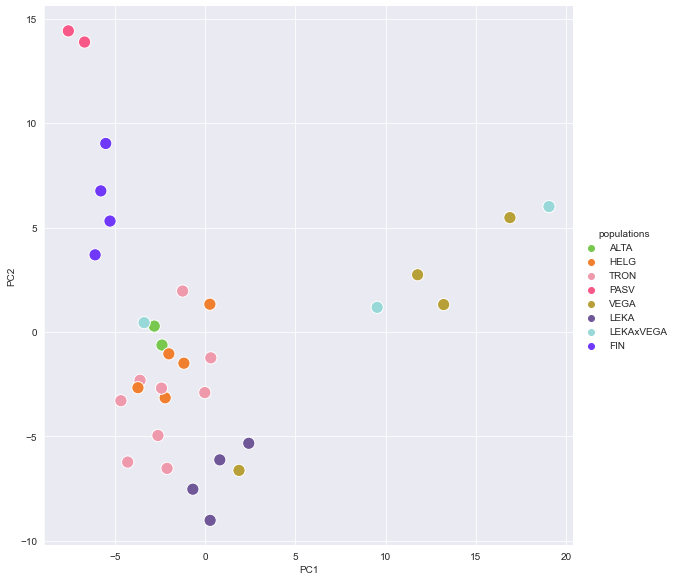

In [98]:
from matplotlib import pyplot
import seaborn


sns.relplot(x="PC1", y="PC2", data=merged2, hue="populations", palette=pagan_poetry, s=(150),height=8, aspect=1)

***Take intersect of Yes calls from all five curators***

In [106]:
%%bash
#First merge all 5 yes .bed files
cp yes_delsh.tsv  yes_delsh.bed
cp yes_delsa.tsv  yes_delsa.bed
cp yes_delsalicia.tsv  yes_delshalicia.bed
cp yes_delserik.tsv  yes_delserik.bed
cp yes_dels.tsv  yes_dels_gab.bed

In [107]:
cat yes_dels_gab.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesdelgab.bed 

In [108]:
cat yes_delsa.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesdel_a.bed

In [109]:
cat yes_delsh.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesdel_h.bed

In [111]:
cat yes_delshalicia.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesdel_alicia.bed

In [112]:
cat yes_delserik.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesdel_erik.bed

In [ ]:
bedops --merge yesdelgab.bed yesdel_a.bed yesdel_h.bed yesdel_alicia.bed yesdel_erik.bed > yesallmerged.bed

In [ ]:
bedops --intersect yesdelgab.bed yesdel_a.bed yesdel_h.bed yesdel_alicia.bed yesdel_erik.bed > yesallintersect.bed

In [113]:
bedtools intersect -f 0.9 -r -a sparrow_edit.bed -b yesallintersect.bed  > yesallintersect.txt

SyntaxError: invalid syntax (<ipython-input-113-e7d54774c548>, line 1)

***Change format of intersected bedfile, repeat this to join 3 first columns with tabs***

In [92]:
cat yesallintersect.txt | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > yesallintersect_edit.txt 

***Convert to .csv for export to python, to tranpose matrix and then plot in R! :-)***

In [93]:
cat yesallintersect_edit.txt | sed 's/\t/,/'g > yesallintersect.csv

In [114]:
df = pd.read_csv("yesallintersect.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("yesallintersect.csv", index = False)

***Now switch to R!***

In [84]:
cat yesmaybe_a.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybedel_a.

In [85]:
cat yesmaybe_h.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybedel_h.

In [86]:
cat yesmaybe_alicia.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybedel_alicia.bed

In [87]:
cat yesmaybe_erik.bed | sed 's/_/\t/g' | sed 's/ /\t/'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybedel_erik.bed

***Use Bedops (https://bedops.readthedocs.io/) to merge all yesmaybe files from all 5 curators!***

***Do bedtools intersect to get the remainder***

In [ ]:
#Get intersect first:

bedtools intersect -f 0.9 -r -a sparrow_edit.bed -b 5curatorsyesmaybe_merged.bed  > maybeyesdelsall5.txt

In [ ]:
bedtools intersect -v -a sparrowall_DELs.bed -b maybeyesdelsall5.txt > rejecteddels3.bed

***Query the smoove .vcf to create a .bed file:***

In [55]:
#bcftools query -f '%CHROM\t%POS\t%END\t%ALT[\t%GT]\n' sparrow_all.smoove.square.vcf.gz | sort -k1,1 -k2,2n | grep CM | grep -v '\[' | grep -v '\]'

***Do bedtools intersect***

In [63]:
%%bash
bedtools intersect -f 0.9 -r -a sparrow_edit.bed -b yesmaybedelgab.bed  > maybeyesdelsgab.txt

Error: unable to open file or unable to determine types for file yesmaybedelgab.bed

- Please ensure that your file is TAB delimited (e.g., cat -t FILE).
- Also ensure that your file has integer chromosome coordinates in the 
  expected columns (e.g., cols 2 and 3 for BED).


***Change format of intersected bedfile, repeat this to join 3 first columns with tabs***

In [92]:
cat mydelgab.txt | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > mydelgab_edit.txt 

In [91]:
cat nomaybeyesdelsgab.txt | sed 's/<DEL>/DEL/g' > mydelgab.txt

***Convert to .csv for export to python, to tranpose matrix and then plot in R! :-)***

In [93]:
cat mydelgab_edit.txt | sed 's/\t/,/'g > mydelgab.csv

In [96]:
df = pd.read_csv("rejecteddels_all.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("rejecteddels_all_T.csv", index = False)

***Take the DELs left over from the Maybes and Yes's***

In [83]:
mv maybeyesdelsgab.txt maybeyesdelsgab.bed

mv: cannot stat ‘maybeyesdelsgab.txt’: No such file or directory


In [84]:
cat maybeyesdelsgab.bed | sed 's/DEL/<DEL>/g' > mygab.bed

In [85]:
%%bash
bedtools intersect -v -a sparrowall_DELs.bed -b mygab.bed  > nomaybeyesdelsgab.txt

***Take the union of everyone's Yes's and Maybes! :-)***

In [ ]:
%%bash
bedops -u sparrowall_DELs.bed mygab.bed > union.bed